In [2]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 21.0 MB/s 


In [3]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, load_model
#from keras.preprocessing.image import load_img, img_to_array
from keras.layers import (Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape)
#from keras.optimizers import Adam
from keras.optimizers import adam_v2
from keras.layers.convolutional import Conv2D,Conv2DTranspose

#import tensorflow as tf
from keras.utils.vis_utils import plot_model

import mtcnn
# example of extracting and resizing faces into a new dataset
from os import listdir
from numpy import asarray
from numpy import savez_compressed
from PIL import Image
from mtcnn.mtcnn import MTCNN
import gdown
from numpy import load

In [17]:
url="https://drive.google.com/uc?id=1qchQ_ObYDuCadgZG_kOZ_UNFLc3dsH3C"
output = "img_align_celeba.npz"
gdown.download(url, output, quiet=True)

'img_align_celeba.npz'

In [18]:
data = load('img_align_celeba.npz')
X_train = data['arr_0']

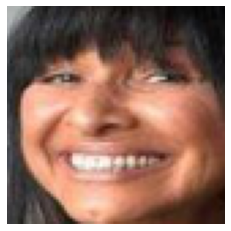

In [ ]:
idx = np.random.randint(0, X_train.shape[0])
plt.axis("off")
plt.imshow((X_train).astype("int32")[idx])

In [ ]:
X_train.shape

(50000, 80, 80, 3)

In [10]:
# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
  model = Sequential()
  # normal
  model.add(Conv2D(128, kernel_size=5, padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
	# downsample to 40x40
  model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
	# downsample to 20x30
  model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
	# downsample to 10x10
  model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
	# downsample to 5x5
  model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
	# classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  
  return model

In [11]:
# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
	# foundation for 5x5 feature maps
  n_nodes = 128 * 5 * 5
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((5, 5, 128)))
	# upsample to 10x10
  model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
	# upsample to 20x20
  model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
	# upsample to 40x40
  model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
	# upsample to 80x80
  model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
	# output layer 80x80x3
  model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
  model.compile()
  return model

In [12]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
	# connect them
  model = Sequential()
	# add generator
  model.add(g_model)
	# add the discriminator
  model.add(d_model)
	# compile model
  model.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(learning_rate=0.0002, beta_1=0.5))
  return model

In [13]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model


# Build the Discriminator
discriminator = define_discriminator()
#plot_model(discriminator, to_file='model.png', show_shapes=True)

# compile model
discriminator.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

z_dim = 100
# Build the Generator
generator = define_generator(z_dim)


# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(learning_rate=0.0002, beta_1=0.5))


In [ ]:
discriminator.summary()
plot_model(discriminator, to_file='model.png', show_shapes=True)

In [ ]:
generator.summary()
plot_model(generator, to_file='model.png', show_shapes=True)

In [14]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(batch_size, sample_interval, n_epochs=10):

    data = load('img_align_celeba.npz')
    X_train = data['arr_0']
    # convert from unsigned ints to floats
    X_train = X_train.astype('float32')
    # scale from [0,255] to [-1,1]
    X_train = X_train / 127.5 - 1.0
    
    
    #for iteration in range(iterations):
    bat_per_epo = int(X_train.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    
    # Labels for real images: all ones
    real = np.ones((half_batch, 1))

    # Labels for real images: all ones
    real_for_gen = np.ones((batch_size, 1))
    
    # Labels for fake images: all zeros
    fake = np.zeros((half_batch, 1))


    for i in range(n_epochs):
        for j in range(bat_per_epo):
            # -------------------------
            #  Train the Discriminator
            # -------------------------

            # Get a random batch of real images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # Generate a batch of fake images
            z = np.random.normal(0, 1, (half_batch, z_dim))
            gen_imgs = generator.predict(z)

            # Train Discriminator
            d_loss_real = discriminator.train_on_batch(imgs, real)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train the Generator
            # ---------------------

            # Generate a batch of fake images
            z = np.random.normal(0, 1, (batch_size, z_dim))
            gen_imgs = generator.predict(z)

            # Train Generator
            g_loss = gan.train_on_batch(z, real_for_gen)

            if (j + 1) % sample_interval == 0 or j == 0 :

                # Save losses and accuracies so they can be plotted after training
                losses.append((d_loss, g_loss))
                accuracies.append(100.0 * accuracy)
                #iteration_checkpoints.append(i + 1)

                # Output training progress
                print("%d %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                      (i + 1, j, d_loss, 100.0 * accuracy, g_loss))

                # Output a sample of generated image
                sample_images(generator)

In [15]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(image_grid_columns*1.5,image_grid_rows*1.5),
                            sharey=True,
                            sharex=True,facecolor='skyblue')

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

In [20]:
#discriminator = load_model('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day05/celeba_discriminator.h5')
generator = load_model('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day05/generater_celeba.h5')
#discriminator.trainable = False
## Build and compile GAN model with fixed Discriminator to train the Generator
#gan = build_gan(generator, discriminator)
#gan.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(learning_rate=0.0002, beta_1=0.5))

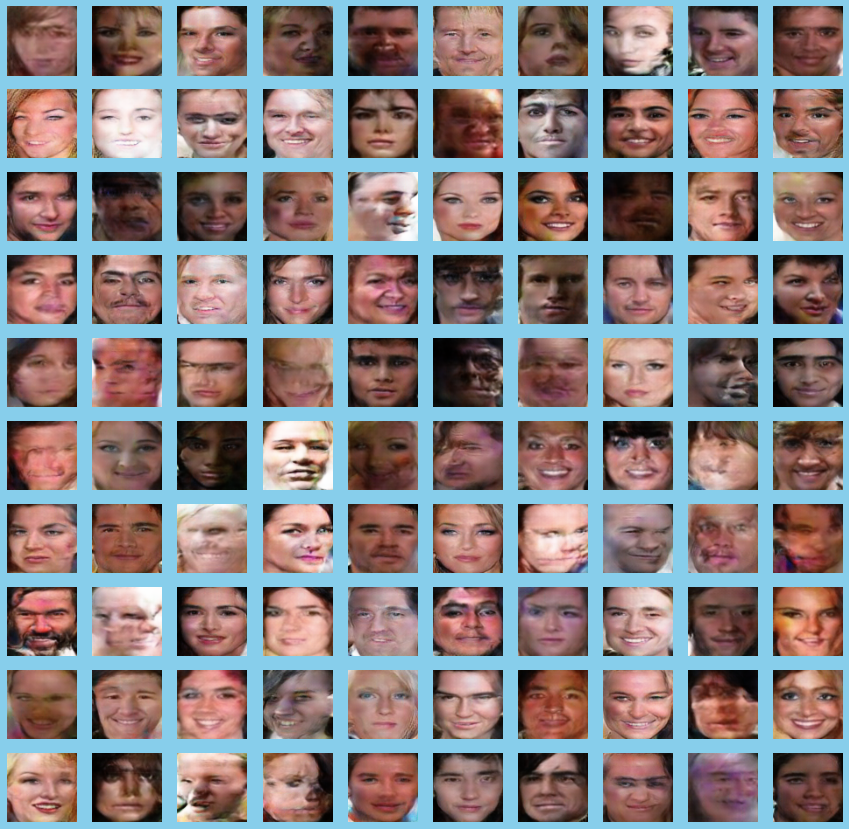

In [22]:
sample_images(generator, image_grid_rows=10, image_grid_columns=10)

1 0 [D loss: 0.698405, acc.: 10.16%] [G loss: 0.692345]


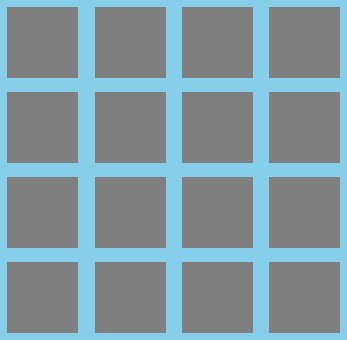

KeyboardInterrupt: ignored

In [19]:
batch_size = 128
sample_interval = 50

# Train the GAN for the specified number of iterations
train(batch_size, sample_interval)
# If you want to save a generator and discriminator, uncommet the lines below.
#generator.save('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day05/celeba_generator.h5')
#discriminator.trainable = True
#discriminator.compile(loss='binary_crossentropy',optimizer=adam_v2.Adam(),metrics=['accuracy'])
#discriminator.save('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day05/celeba_discriminator.h5')